---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Moiz Deshmukh
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
# Import Libraries
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Set Plotly Renderer
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .csv("lightcast_job_postings.csv")   # Adjust path if needed

df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/14 16:31:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/14 16:31:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
from pyspark.sql.functions import col, when

# Create Average Salary Column
df = df.withColumn(
    "Average_Salary",
    when(
        (col("SALARY_FROM").isNotNull()) & (col("SALARY_TO").isNotNull()),
        (col("SALARY_FROM") + col("SALARY_TO")) / 2
    ).otherwise(col("SALARY"))
)

# Check if Average_Salary is created
df.select("Average_Salary", "SALARY_FROM", "SALARY_TO", "SALARY").show(7)


+--------------+-----------+---------+------+
|Average_Salary|SALARY_FROM|SALARY_TO|SALARY|
+--------------+-----------+---------+------+
|          NULL|       NULL|     NULL|  NULL|
|          NULL|       NULL|     NULL|  NULL|
|          NULL|       NULL|     NULL|  NULL|
|          NULL|       NULL|     NULL|  NULL|
|       92500.0|      35000|   150000| 92500|
|      110155.0|      94420|   125890|110155|
|          NULL|       NULL|     NULL|  NULL|
+--------------+-----------+---------+------+
only showing top 7 rows



In [3]:
# Select only important columns
df_selected = df.select(
    "Average_Salary",
    "MAX_YEARS_EXPERIENCE",
    "REMOTE_TYPE_NAME"
)

# Check
df_selected.show(5)


+--------------+--------------------+----------------+
|Average_Salary|MAX_YEARS_EXPERIENCE|REMOTE_TYPE_NAME|
+--------------+--------------------+----------------+
|          NULL|                   2|          [None]|
|          NULL|                   3|          Remote|
|          NULL|                NULL|          [None]|
|          NULL|                NULL|          [None]|
|       92500.0|                NULL|          [None]|
+--------------+--------------------+----------------+
only showing top 5 rows



In [4]:
# Drop rows with missing values in key columns
df_cleaned = df_selected.dropna(subset=["Average_Salary", "MAX_YEARS_EXPERIENCE", "REMOTE_TYPE_NAME"])

# Check again
df_cleaned.show(5)


+--------------+--------------------+----------------+
|Average_Salary|MAX_YEARS_EXPERIENCE|REMOTE_TYPE_NAME|
+--------------+--------------------+----------------+
|       92962.0|                   2|          [None]|
|      165000.0|                   8|          [None]|
|       75026.0|                   2|          [None]|
|       97500.0|                   5|      Not Remote|
|       60923.0|                   1|          Remote|
+--------------+--------------------+----------------+
only showing top 5 rows



In [5]:
df_cleaned = df_cleaned.filter(df_cleaned.REMOTE_TYPE_NAME != "[None]")

In [6]:
df_cleaned.show(5)

+--------------+--------------------+----------------+
|Average_Salary|MAX_YEARS_EXPERIENCE|REMOTE_TYPE_NAME|
+--------------+--------------------+----------------+
|       97500.0|                   5|      Not Remote|
|       60923.0|                   1|          Remote|
|      136950.0|                   3|          Remote|
|      136950.0|                   3|          Remote|
|      136950.0|                   3|          Remote|
+--------------+--------------------+----------------+
only showing top 5 rows



In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 1: String Indexer (convert text to index)
indexer = StringIndexer(inputCol="REMOTE_TYPE_NAME", outputCol="REMOTE_TYPE_INDEX")
df_indexed = indexer.fit(df_cleaned).transform(df_cleaned)

# Step 2: One Hot Encoder (convert index to one-hot vector)
encoder = OneHotEncoder(inputCol="REMOTE_TYPE_INDEX", outputCol="REMOTE_TYPE_OHE")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Check the result
df_encoded.select("REMOTE_TYPE_NAME", "REMOTE_TYPE_INDEX", "REMOTE_TYPE_OHE").show(5, truncate=False)


+----------------+-----------------+---------------+
|REMOTE_TYPE_NAME|REMOTE_TYPE_INDEX|REMOTE_TYPE_OHE|
+----------------+-----------------+---------------+
|Not Remote      |2.0              |(2,[],[])      |
|Remote          |0.0              |(2,[0],[1.0])  |
|Remote          |0.0              |(2,[0],[1.0])  |
|Remote          |0.0              |(2,[0],[1.0])  |
|Remote          |0.0              |(2,[0],[1.0])  |
+----------------+-----------------+---------------+
only showing top 5 rows



In [8]:
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["MAX_YEARS_EXPERIENCE", "REMOTE_TYPE_OHE"], 
    outputCol="features"
)

df_final = assembler.transform(df_encoded)

# Show final output
df_final.select("Average_Salary", "features").show(5, truncate=False)


+--------------+-------------+
|Average_Salary|features     |
+--------------+-------------+
|97500.0       |[5.0,0.0,0.0]|
|60923.0       |[1.0,1.0,0.0]|
|136950.0      |[3.0,1.0,0.0]|
|136950.0      |[3.0,1.0,0.0]|
|136950.0      |[3.0,1.0,0.0]|
+--------------+-------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [9]:
# Splitting data (80/20 split)
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=999)

# records seeing
print("Training Data Count:", train_data.count())
print("Test Data Count:", test_data.count())


Training Data Count: 818


Test Data Count: 210


I am choosing an 80/20 train-test split to ensure the model has sufficient data to learn (80%) while reserving 20% unseen data for evaluation.

# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [10]:
from pyspark.ml.regression import LinearRegression

# Initialize and fit model
lr = LinearRegression(featuresCol="features", labelCol="Average_Salary")
lr_model = lr.fit(train_data)

# Print Coefficients and Intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")


25/04/14 16:31:49 WARN Instrumentation: [1ed3543b] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [7872.219537147417,12451.762907967144,2747.332623948653]
Intercept: 70209.28665372715


In [11]:
# Make predictions on the test set
test_results = lr_model.evaluate(test_data)

# Print RMSE, R², and MAE
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")
print(f"R-squared (R²): {test_results.r2}")
print(f"Mean Absolute Error (MAE): {test_results.meanAbsoluteError}")


Root Mean Squared Error (RMSE): 28567.671996199068
R-squared (R²): 0.30853234851036027
Mean Absolute Error (MAE): 23864.639516574553


In [12]:
# Get the training summary
training_summary = lr_model.summary

# Diagnostic check (you don't need to print this in final doc)
print(f"Length of features: {len(training_summary.featuresCol)}")
print(f"Length of coefficients: {len(training_summary.coefficientStandardErrors)}")
print(f"Length of standard errors (se): {len(training_summary.coefficientStandardErrors)}")
print(f"Length of t-values (tvals): {len(training_summary.tValues)}")
print(f"Length of p-values (pvals): {len(training_summary.pValues)}")


Length of features: 8
Length of coefficients: 4
Length of standard errors (se): 4
Length of t-values (tvals): 4
Length of p-values (pvals): 4


In [13]:
summary = lr_model.summary

In [14]:
feature_names = ["Intercept"] + [f"Feature_{i}" for i in range(len(lr_model.coefficients))]

coefs_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": [lr_model.intercept] + list(lr_model.coefficients),
    "StdError": summary.coefficientStandardErrors,
    "tValue": summary.tValues,
    "pValue": summary.pValues
})

coefs_df

,Feature,Coefficient,StdError,tValue,pValue
0,Intercept,70209.286654,474.410220,16.593697,0.000000
1,Feature_0,7872.219537,5099.659543,2.441685,0.014831
2,Feature_1,12451.762908,5924.833913,0.463698,0.642988
3,Feature_2,2747.332624,5289.616331,13.273040,0.000000


In [15]:
# Re-run this if needed
predictions = lr_model.transform(test_data)


In [16]:
# Convert predictions to Pandas and calculate residuals
pdf = predictions.select("Average_Salary", "prediction").toPandas()
pdf["residuals"] = pdf["Average_Salary"] - pdf["prediction"]

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [22]:
for idx, feature in enumerate(features):
    print(f"{idx}: {feature}")


0: Intercept
1: Feature_0
2: Feature_1
3: Feature_2


## Generalized Linear Regression Summary Interpretation

The table above shows the feature names corresponding to the coefficients output by the regression model.

- **Intercept (0)**: The expected value of the target variable (Average Salary) when all other features are 0.
- **Feature_0 (1)**: Represents the first predictor used in the model. Based on our feature engineering, this likely corresponds to **MAX_YEARS_EXPERIENCE**.
- **Feature_1 (2)**: Represents the second predictor. This is likely related to **REMOTE_TYPE_NAME (Not Remote, Remote, etc.)** based on the one-hot encoding.
- **Feature_2 (3)**: Represents another encoded feature from **REMOTE_TYPE_NAME**.

Each feature's coefficient estimate indicates how much it is expected to impact the predicted salary, holding other variables constant.  
Additionally, the t-statistics and p-values associated with each coefficient help determine whether the corresponding feature has a statistically significant relationship with the salary.

Low p-values (typically < 0.05) suggest strong evidence against the null hypothesis, meaning


# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


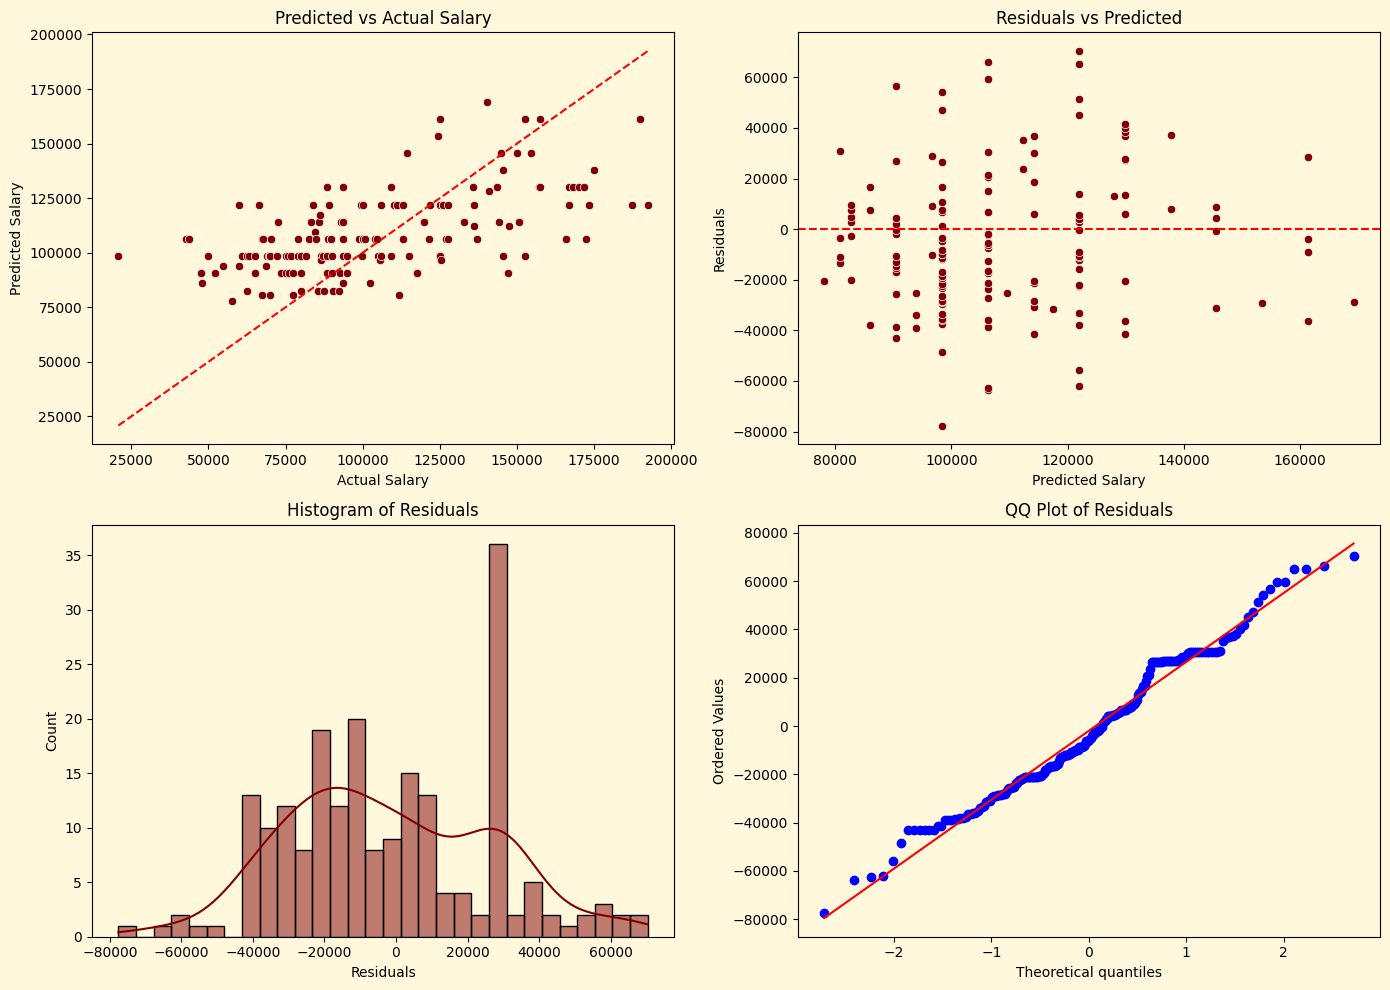

In [26]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Set plot style
plt.style.use('default')  # Reset to default first
plt.rcParams['axes.facecolor'] = '#FFF8DC'   # Light cream background for plots
plt.rcParams['figure.facecolor'] = '#FFF8DC' # Light cream background for figure
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set figure size
plt.figure(figsize=(14, 10))

# 1. Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x=pdf["Average_Salary"], y=pdf["prediction"], color="#800000")  # maroon color
plt.plot(
    [pdf["Average_Salary"].min(), pdf["Average_Salary"].max()],
    [pdf["Average_Salary"].min(), pdf["Average_Salary"].max()],
    color="red", linestyle="--"
)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")

# 2. Residuals vs Predicted
plt.subplot(2, 2, 2)
sns.scatterplot(x=pdf["prediction"], y=pdf["residuals"], color="#800000")  # maroon color
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(pdf["residuals"], bins=30, kde=True, color="#800000")  # maroon color
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")

# 4. QQ Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(pdf["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

# Layout adjustment
plt.tight_layout()
plt.show()


# Diagnostic Plots Interpretation

## 1. Predicted vs Actual Plot
The points are generally scattered around the red diagonal line, which indicates that the model is making decent predictions. However, there is some spread away from the line, suggesting that the model is not perfect and there is some prediction error.

## 2. Residuals vs Predicted Plot
The residuals appear randomly scattered around the horizontal line at zero, without forming any clear pattern. This suggests that the assumptions of linearity and homoscedasticity (constant variance) are reasonably satisfied. However, some spread at different levels of prediction indicates slight heteroscedasticity.

## 3. Histogram of Residuals
The histogram of residuals is roughly symmetric but not perfectly normal. There are some visible spikes and deviations, suggesting that the residuals may not be perfectly normally distributed. This could slightly impact the reliability of statistical tests.

## 4. QQ Plot of Residuals
The points in the QQ plot mostly follow the 45-degree red line, but there are deviations at the ends (tails), indicating slight non-normality in the residuals. However, for many practical purposes, the residuals are close enough to normal.


# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [28]:
# Import libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Predict on test data
pred_glr = lr_model.transform(test_data)

# R² Calculation
evaluator = RegressionEvaluator(labelCol="Average_Salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(pred_glr)
print(f"R² (Coefficient of Determination): {r2:.4f}")

# BIC Calculation
n = pred_glr.count()
k = len(lr_model.coefficients) + 1   # number of features + intercept
rss = pred_glr.withColumn("sq_error", pow(col("Average_Salary") - col("prediction"), 2)).agg({"sq_error": "sum"}).collect()[0][0]
bic = n * np.log(rss / n) + k * np.log(n)
print(f"BIC: {bic:.4f}")

# RMSE manually
residuals_df = pred_glr.withColumn("residuals", col("Average_Salary") - col("prediction"))
rmse = residuals_df.withColumn("sq_residuals", pow(col("residuals"), 2)) \
                   .agg(sqrt(avg(col("sq_residuals"))).alias("rmse")) \
                   .collect()[0]["rmse"]
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


R² (Coefficient of Determination): 0.3085


BIC: 4330.6015


RMSE (Root Mean Squared Error): 28567.6720


### Evaluation Summary

**R² (Coefficient of Determination):**  
The R² value obtained is **0.3085**.  
This indicates that approximately **30.85%** of the variance in the average salary is explained by the model. Although the model captures some of the variability, there is still a significant portion of variance not explained, suggesting potential for model improvement.

**BIC (Bayesian Information Criterion):**  
The BIC value is **4330.6015**.  
A lower BIC generally indicates a better model by balancing model fit with complexity. However, BIC values are mainly useful when comparing multiple models trained on the same data.

**RMSE (Root Mean Squared Error):**  
The RMSE is **28567.6720**.  
This means that the average error between the predicted and actual salary values is about **$28,567**. A lower RMSE indicates better predictive accuracy. The current RMSE suggests there is room for enhancing model performance.


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

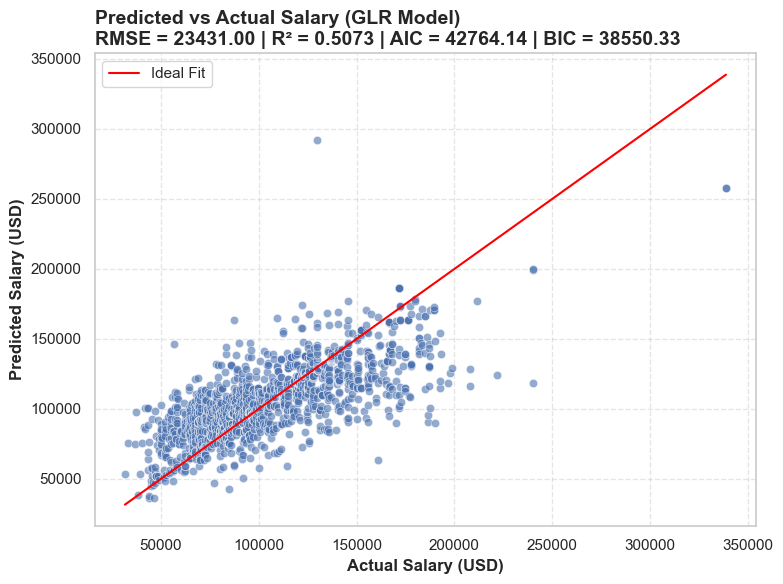

In [ ]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = 

# Plot
plt.figure(figsize=(8, 6))


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
